# 4. Technical notebook for Movielens engine recommendation 

In this delivery I will attempt to answer the question “What movie should I watch this evening?” by modelling MovieLens data.

# Exploratory analysis summary

Our main variables are ratings, genres, movie titles and users.

Ratings tend to be quite positive overall. Different variables other than the quality of movies could be impacting user's ratings.

The most popular movie genres are Drama, Comedy, Action, Thriller, and Romance.
The top five most watch movie titles are:

American Beauty (1999) 
Jurassic Park (1993) 
Saving Private Ryan (1998) 
Matrix, The (1999) 
Back to the Future (1985)

The demographic profile of our users is mainly males, aged 18 - 44 years old, working in a variety of occupations (e.g. students, professionals, academics and technicians) and located across US states.

# Modelling approach

We could be exploring different types of approaches for our movie recommendation as per James Lee blog post: 
https://medium.com/@james_aka_yale/the-4-recommendation-engines-that-can-predict-your-movie-tastes-bbec857b8223

Types of Recommendation Engines we could explore as per James Lee blog post are:

1. Content-Based

Benefits:
Easy to implement due to no training or optimization is involved.
No need for data on other users, thus no cold-start or sparsity problems.
Can recommend to users with unique tastes.
Can recommend new & unpopular items.
Can provide explanations for recommended items by listing content-features that caused an item to be recommended (in this case, movie genres)

Drawbacks:
Finding the appropriate features is hard.
Does not recommend items outside a user’s content profile.
Unable to exploit quality judgments of other users.
Model performance decrease when having sparse data which hinders scalability of approach.



2. Memory-Based Collaborative Filtering

Benefits:
Easy to implement due to no training or optimization is involved
Reasonable prediction quality.

Drawbacks:
It doesn't address the cold-start problem, that is when new user or new item enters the system.
It can't deal with sparse data, meaning it's hard to find users that have rated the same items.
It suffers when new users or items that don't have any ratings enter the system.
It tends to recommend popular items.
It doesn’t scale particularly well to massive datasets, especially for real-time recommendations based on user behavior similarities — which takes a lot of computations.
Ratings matrices may be overfitting to noisy representations of user tastes and preferences. 



3. Model-Based Collaborative Filtering (based on Matrix Factorization)

The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. James Less applied Dimensionality Reduction techniques to derive the tastes and preferences from the raw data and Singular Vector Decomposition (SVD)

Benefits:
Widely used for recommender systems 
It deals better with scalability and sparsity than Memory-based CF 
   
Drawbacks:
Singular Vector Decomposition (SVD) is an outdated methodology and would be better using newer factorisation methods.
Some of those could be PCA or Non-Negative Matrix Factorisation because they build on SVD. 


4. Deep Learning / Neural Network

This is similar to Model-Based Matrix Factorization but the sparse matrix doesn't have to be orthogonal. 
We want our model to learn the values of embedding matrix itself. The user latent features and movie latent features are looked up from the embedding matrices for specific movie-user combination. These are the input values for further linear and non-linear layers. We can pass this input to multiple relu, linear or sigmoid layers and learn the corresponding weights by any optimization algorithm 

Benefits:
This model performed better than all the approaches James Lee attempted before. 

Drawbacks:
High computer performance needed
Important investment of time needed in tunning the model
Highly complex model with difficulty for troubleshooting 
Last lesson of this course which means no practical knowledge of methodology as yet


After researching on what's the best approach for our model considering the project and data set constrains I decided to implement a recommendation engine that doesn't consider users ratings because the variable is not always available and I would like the model to be as replicable as possible in other scenarios. My aim is to make meaninful movie recommendations in this case with the least user information needed so we can reuse our model in other contexts (e.g. recommend unrated events on a different website)

For this, I will attempt to use the Latent Dirichlet Allocation (LDA) modelling method which assumes that the data we are observing has some hidden, underlying structure that we can't see, and which we'd like to learn. These hidden, underlying structure are the _latent_ variables we want our model to understand.

In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's creation is attributable to one of the document's topics. LDA is an example of a topic model. Source: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

My goal is grouping the movie titles watched into themes so recommendations are generated based on top movies within a specific theme that the user hasn't watched yet.

Therefore, I expect my model to be similar to James Lee's Model-Based Collaborative Filtering but using a more sophisticated method as LDA is meant to be. I am also inpiring my project on the New York Times recommendation engine blog post located here:
https://open.blogs.nytimes.com/2015/08/11/building-the-next-new-york-times-recommendation-engine/?_r=0

Benefits:
Widely used for recommender systems. LDA is central to topic modeling and has really revolutionized the field
LDA tends to perform well on small datasets because Bayesian methods can avoid overfitting the data
It deals better with scalability and sparsity than Memory-based CF 
LDA is a probabilistic model with interpretable topics
LDA gives you categories for free, in any data set

Drawbacks:
It's hard to know when LDA is working because themes are soft-clusters so there is no objective metric to say "this is the best choice" of hyperparameters
Fixed K (the number of themes is fixed and must be known ahead of time)
Uncorrelated topics (Dirichlet theme distribution cannot capture correlations)
Non-hierarchical (in data-limited regimes hierarchical models allow sharing of data)
Static (no evolution of themes over time)
Bag of words (assumes words are exchangeable, sentence structure is not modeled)
Unsupervised (sometimes weak supervision is desirable, e.g. in sentiment analysis)
The accuracy of statistical inference (which is the base of LDA) depends on the number of observations.

# Data transformations needed pre modelling

In [2]:
#imports
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as pl
import numpy as np
import seaborn as sns
%matplotlib inline
import gensim
import spacy
nlp_toolkit = spacy.load("en")

## Load spacy
import spacy

# Setting up spacy
nlp = spacy.load('en')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

#Regular expressions
import regex as re

# Gensim is used for LDA (and other models)
from gensim.models.ldamulticore import LdaModel
from gensim.matutils import Sparse2Corpus

# Setting up spacy
nlp = spacy.load('en')

C:\Users\loida\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
# Bringing in movie frequency data (unpickling my moviewatchedrank dataframe)
unpickled_moviewatchedrank = pd.read_pickle('moviefreq.pkl')

#Reassigning
movie_freq = unpickled_moviewatchedrank
movie_freq.head()

,MovieID,Users_count
2651,2858,3428
466,480,2672
1848,2028,2653
2374,2571,2590
1178,1270,2583


In [12]:
# Bringing in rest of data (unpickling my dfc dataframe)
unpickled_dfc = pd.read_pickle('dfc.pkl')

#Reassigning
dfc = unpickled_dfc
dfc.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


In [13]:
#Swapping MovieIDs (movie_freq) for Movie titles (dfc)
movie_freq1 = movie_freq.join(dfc.Title, on='MovieID',how='inner', lsuffix='movie_freq', rsuffix='', sort=False)
movie_freq1.head()

#Re ordering my columns and sorting by users count descending
titles_freq = movie_freq1.reindex (columns=['MovieID','Title','Users_count'])
titles_freqc = titles_freq.sort_values('Users_count', ascending=False)
titles_freqc.head()


,MovieID,Title,Users_count
2651,2858,"Misérables, Les (1998)",3428
466,480,Superman (1978),2672
1848,2028,Babes in Toyland (1961),2653
2374,2571,"Brady Bunch Movie, The (1995)",2590
1178,1270,Four Weddings and a Funeral (1994),2583


# Model 1 - Latent variable modelling with LDA

Latent Dirichlet Allocation mixture model generates more structure around the documents (in this case movie titles) by creating clusters of common words and generating probability distributions to explicitly state how related the words are.

The latent structure we want to uncover are the topics of movies generated by the movies titles. For this, we will adjust our movie titles first and then fit the model.

In [14]:
#Removing years from movie titles because there are no movies with more than one release date 
#in my data set so the year info doesn't add any value to my titles

titles_freqc.Title = titles_freqc.Title.str[:-6]
titles_freqc.head()

,MovieID,Title,Users_count
2651,2858,"Misérables, Les",3428
466,480,Superman,2672
1848,2028,Babes in Toyland,2653
2374,2571,"Brady Bunch Movie, The",2590
1178,1270,Four Weddings and a Funeral,2583


In [15]:
#Making movie titles lower case and removing special characters and others within text in an additional column

# titles_freqc['lower_desc'] = map(lambda x: x.lower(), titles_freqc['Title'])
titles_freqc['titles_lower']   = titles_freqc['Title'].apply(lambda x: x.lower())
titles_freqc['titles_lower']   = titles_freqc['titles_lower'].apply(lambda x: x.replace(',','').replace('-','').replace('(','').replace(')','').replace('?',''))
titles_freqc['titles_lower']   = titles_freqc['titles_lower'].apply(lambda x: x.replace('&','').replace('.','').replace('!','').replace('/','').replace('\'',''))         

titles_freqc.head()

,MovieID,Title,Users_count,titles_lower
2651,2858,"Misérables, Les",3428,misérables les
466,480,Superman,2672,superman
1848,2028,Babes in Toyland,2653,babes in toyland
2374,2571,"Brady Bunch Movie, The",2590,brady bunch movie the
1178,1270,Four Weddings and a Funeral,2583,four weddings and a funeral


# Step change for future use

In [16]:
#Re assigning to a new dataframe for future use in transformation

titles_trans = titles_freqc[['titles_lower', 'Users_count']]
titles_trans.head()

,titles_lower,Users_count
2651,misérables les,3428
466,superman,2672
1848,babes in toyland,2653
2374,brady bunch movie the,2590
1178,four weddings and a funeral,2583


In [32]:
#Removing spaces between words in titles_lower
titles_freqc['titles_lower'] = titles_freqc['titles_lower'].str.replace(' ', '')
titles_freqc.head(20)

,MovieID,Title,Users_count,titles_lower
2651,2858,"Misérables, Les",3428,misérablesles
466,480,Superman,2672,superman
1848,2028,Babes in Toyland,2653,babesintoyland
2374,2571,"Brady Bunch Movie, The",2590,bradybunchmoviethe
1178,1270,Four Weddings and a Funeral,2583,fourweddingsandafuneral
579,593,Titanic,2578,titanic
1449,1580,House of Dracula,2538,houseofdracula
1108,1198,Notting Hill,2514,nottinghill
593,608,"Untouchables, The",2513,untouchablesthe
2557,2762,Hard-Boiled (Lashou shentan),2459,hardboiledlashoushentan


In [10]:
#Brining movie genres in to better understand theme composition down the line
titles_freqg = titles_freqc.join(dfc['Genres'])
titles_freqg.head()

,MovieID,Title,Users_count,titles_lower,Genres
2651,2858,"Misérables, Les",3428,misérables les,Adventure|Children's|Comedy|Musical
466,480,Superman,2672,superman,Animation|Sci-Fi
1848,2028,Babes in Toyland,2653,babes in toyland,Crime|Drama|Sci-Fi
2374,2571,"Brady Bunch Movie, The",2590,brady bunch movie the,Comedy
1178,1270,Four Weddings and a Funeral,2583,four weddings and a funeral,Comedy


# LDA in Gensim - 1st take

In [206]:
#This step is not needed at the moment but could be needed in the future so will leave it just in case

#Adding stop words to exclusion list

#def cust_stop_list(lists):
    '''
    Take a list of lists and looks for specific strings.
    Adds to stop_list

    '''

    #stop_list = []

    #for line in lists:
        #words = line.split(' ')
        #for word in words:
            #if '1930' in word:
                #stop_list.append(word)  
            #if '1945' in word:
                #stop_list.append(word)
    #return(stop_list)

#Conditionals on year should be done with a regex but can't seem to make it work atm

#stop_list = cust_stop_list(titles_freqc.Title)
#print(stop_list[:20])

[]


In [25]:
#This step is not needed at the moment but could be needed in the future so will leave it just in case
#Checking stop words list

#stop_words = text.ENGLISH_STOP_WORDS
#print(stop_words)

In [26]:
#This step is not needed at the moment but could be needed in the future so will leave it just in case
#Adding custom stop words list

#cust_stop_words = stop_words.union(stop_list)
#print(cust_stop_words)

In [11]:
#Tuning model with the whole set of data (titles_freqg)


df_LDAI= pd.DataFrame({'titles_lower': titles_freqg['titles_lower']})

cvI = CountVectorizer(binary = False)

docsI = cvI.fit_transform(titles_freqg['titles_lower'].dropna())

#Build a mapping of numerical ID to word
id2word = dict(enumerate(cvI.get_feature_names()))

id2word

{0: '10',
 1: '101',
 2: '12',
 3: '13',
 4: '13th',
 5: '1600',
 6: '17',
 7: '187',
 8: '2000',
 9: '20000',
 10: '2010',
 11: '28',
 12: '34th',
 13: '37th',
 14: '42nd',
 15: '54',
 16: '60',
 17: '66',
 18: '7th',
 19: '80',
 20: '8th',
 21: 'abbott',
 22: 'abbotts',
 23: 'about',
 24: 'absent',
 25: 'absolute',
 26: 'abyss',
 27: 'academy',
 28: 'acres',
 29: 'across',
 30: 'act',
 31: 'action',
 32: 'adams',
 33: 'addams',
 34: 'ado',
 35: 'adventure',
 36: 'adventures',
 37: 'advocate',
 38: 'ae',
 39: 'affair',
 40: 'africa',
 41: 'african',
 42: 'afternoon',
 43: 'again',
 44: 'age',
 45: 'agnes',
 46: 'agua',
 47: 'air',
 48: 'airheads',
 49: 'airplane',
 50: 'airport',
 51: 'aka',
 52: 'akira',
 53: 'aladdin',
 54: 'albino',
 55: 'alice',
 56: 'alien',
 57: 'aliens',
 58: 'alien³',
 59: 'alive',
 60: 'all',
 61: 'alligator',
 62: 'almost',
 63: 'alone',
 64: 'amadeus',
 65: 'america',
 66: 'american',
 67: 'amigos',
 68: 'amistad',
 69: 'amy',
 70: 'an',
 71: 'anaconda',
 7

In [44]:
#We convert our word-matrix into gensim's format
corpus = Sparse2Corpus(docsI, documents_columns = False)

#Then we fit an LDA model. I will check for 5 topics for now because my movies are distributed across 
#5 different genres as per exploratory analysis findings and want to have an initial look at results

lda_modelI = LdaModel(corpus = corpus, id2word = id2word, num_topics = 5, iterations = 100000)
lda_modelI.show_topics()


[(0,
  '0.013*"predator" + 0.012*"matrixthe" + 0.012*"breakfastattiffanys" + 0.011*"mummythe" + 0.011*"planetoftheapes" + 0.010*"runlolarunlolarennt" + 0.009*"silenceofthelambsthe" + 0.009*"braveheart" + 0.008*"timebandits" + 0.008*"capefear"'),
 (1,
  '0.012*"meninblack" + 0.011*"snowwhiteandthesevendwarfs" + 0.011*"terminatorthe" + 0.010*"marypoppins" + 0.010*"lastofthemohicansthe" + 0.010*"abyssthe" + 0.010*"forrestgump" + 0.010*"truelies" + 0.010*"toystory2" + 0.010*"galaxyquest"'),
 (2,
  '0.014*"godfatherthe" + 0.013*"gonewiththewind" + 0.012*"flythe" + 0.011*"pulpfiction" + 0.010*"xmen" + 0.010*"americanbeauty" + 0.010*"shawshankredemptionthe" + 0.010*"clearandpresentdanger" + 0.010*"tokillamockingbird" + 0.010*"standbyme"'),
 (3,
  '0.015*"oneflewoverthecuckoosnest" + 0.015*"jurassicpark" + 0.010*"groundhogday" + 0.010*"closeencountersofthethirdkind" + 0.010*"danceswithwolves" + 0.010*"ghostbusters" + 0.010*"usualsuspectsthe" + 0.010*"shakespeareinlove" + 0.009*"laconfidential"

# Evaluating the model fit

In the model above, we need to explicitly specify the number of topics we want the model to uncover. This is a critical step but unfortunately there is not a lot of guidance on the best way to select it. Having domain knowledge about your data may help.

Once we have fit this model, like other unsupervised learning techniques, most of our validation techniques are mostly about interpretation.

I did try several combinations of numbers of topics and iterations with not obvious meaningful results. The topics obtained do not seem to have anything in common in my opinion. I will evaluate this by viewing the top words for each topic.

In [45]:
# A way of evaluating the model fit is by looking at the top words in each topic with gensim how_topics function
#I expect some topics to represent some concepts clearly but others not so much.

num_topics = 5
num_words_per_topic = 3
for ti, topic in enumerate(lda_modelI.show_topics(num_topics, num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

Topic: 0
(0, '0.013*"predator" + 0.012*"matrixthe" + 0.012*"breakfastattiffanys"')

Topic: 1
(1, '0.012*"meninblack" + 0.011*"snowwhiteandthesevendwarfs" + 0.011*"terminatorthe"')

Topic: 2
(2, '0.014*"godfatherthe" + 0.013*"gonewiththewind" + 0.012*"flythe"')

Topic: 3
(3, '0.015*"oneflewoverthecuckoosnest" + 0.015*"jurassicpark" + 0.010*"groundhogday"')

Topic: 4
(4, '0.009*"savingprivateryan" + 0.009*"huntforredoctoberthe" + 0.008*"wizardofozthe"')



Overall, our topics and first three 'words' within topics do not seem to have an obvious meaning regardless of number of topics and iterations selected. 

# Improving the results of topic modeling

Following the inconclusive results of our model, I decided to apply a filter on frequency on MovieLens dataset in an effort of improving the results of our model. 

A frequency filter arranges every term according to its frequency. Terms with higher frequencies are more likely to appear in the results as compared ones with low frequency. The low frequency terms are essentially weak features of the corpus, hence it is a good practice to get rid of all those weak features. An exploratory analysis of terms and their frequency can help to decide what frequency value should be considered as the threshold.

https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [46]:
#Making a subset of titles and user counts only and sorting user counts descending

titles_table = titles_freqg[['titles_lower', 'Users_count']].sort_values('Users_count',ascending=False)
titles_table.head()

,titles_lower,Users_count
2651,misérablesles,3428
466,superman,2672
1848,babesintoyland,2653
2374,bradybunchmoviethe,2590
1178,fourweddingsandafuneral,2583


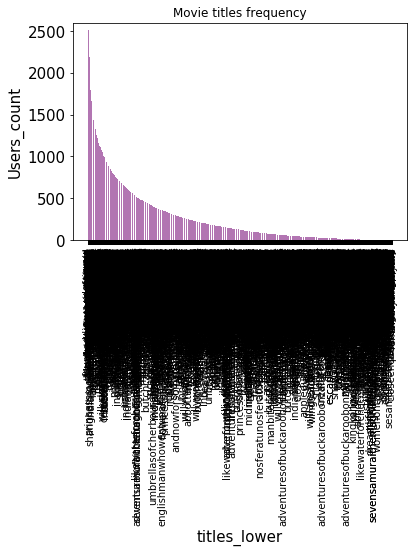

In [47]:
#Plotting movie titles frequency to idenfity those titles that represent the weakest features in out LDA model 
#to improve our topic modelling results 

height = titles_table['Users_count']
bars = titles_table['titles_lower']
y_pos = np.arange(len(bars))

# Create bars and choose color
plt.bar(y_pos, height, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Movie titles frequency')
plt.xticks(size = 10)
plt.yticks(size = 15)
plt.xlabel('titles_lower', size = 15)
plt.ylabel('Users_count', size = 15)
 
# Limits for the Y axis
plt.ylim(0,2600)
 
# Create names
plt.xticks(y_pos, bars, rotation=90)
 
# Show graphic
plt.show()


In [48]:
#Finding median and quartiles of user_count column to decide threshold where to remove the weakest features in our dataset.

#I will remove any user counts with values under 100 based on the first quartile and median figures diplayed here:

titles_table['Users_count'].quantile([0.25,0.5,0.75])

0.25     32
0.50    122
0.75    352
Name: Users_count, dtype: object

In [49]:
#Drop rows where user count is less than 100

titles_subtable = titles_table[titles_table['Users_count'] >= 100]

#Checking
#titles_subtable['Users_count'].min()

titles_subtable[['titles_lower', 'Users_count']].sort_values('Users_count',ascending=True).head(5)

,titles_lower,Users_count
2712,bound,100
25,titanic,100
1264,closeencountersofthethirdkind,100
431,pi,100
1602,benhur,100


# LDA in Gensim - 2nd take

In [51]:
#Tuning model with a subset of my data (titles_subtable) instead of the whole set (titles_freqg)

df_LDAII= pd.DataFrame({'titles_lower': titles_subtable['titles_lower']})

cvII = CountVectorizer(binary = False)

docsII = cvII.fit_transform(titles_subtable['titles_lower'].dropna())

#Build a mapping of numerical ID to word
id2wordII = dict(enumerate(cvII.get_feature_names()))

id2wordII

{0: '101dalmatians',
 1: '13thwarriorthe',
 2: '20000leaguesunderthesea',
 3: '2010',
 4: '28days',
 5: '2daysinthevalley',
 6: '7thvoyageofsinbadthe',
 7: 'abbottandcostellomeetfrankenstein',
 8: 'absentmindedprofessorthe',
 9: 'absolutepower',
 10: 'abyssthe',
 11: 'addamsfamilythe',
 12: 'addamsfamilyvalues',
 13: 'adventuresinbabysitting',
 14: 'adventuresofbuckaroobonzaiacrossthe8thdimensionthe',
 15: 'adventuresofpriscillaqueenofthedesertthe',
 16: 'adventuresofrobinhoodthe',
 17: 'africanqueenthe',
 18: 'ageofinnocencethe',
 19: 'agnesofgod',
 20: 'airforceone',
 21: 'airplane',
 22: 'airport',
 23: 'akira',
 24: 'aladdin',
 25: 'aladdinandthekingofthieves',
 26: 'albinoalligator',
 27: 'aliceinwonderland',
 28: 'alien',
 29: 'aliennation',
 30: 'aliens',
 31: 'alien³',
 32: 'alive',
 33: 'allabouteve',
 34: 'alldogsgotoheaven',
 35: 'allquietonthewesternfront',
 36: 'almostfamous',
 37: 'amadeus',
 38: 'americanbeauty',
 39: 'americangraffiti',
 40: 'americanpie',
 41: 'america

In [54]:
#We convert our word-matrix into gensim's format
corpusI = Sparse2Corpus(docsII, documents_columns = False)

lda_modelII = LdaModel(corpus = corpus, id2word = id2word, num_topics = 5, iterations = 100000)
lda_modelII.show_topics()

[(0,
  '0.014*"godfatherthe" + 0.013*"gonewiththewind" + 0.011*"predator" + 0.010*"wizardofozthe" + 0.010*"snowwhiteandthesevendwarfs" + 0.010*"planetoftheapes" + 0.009*"matrixthe" + 0.009*"schindlerslist" + 0.008*"ghostbusters" + 0.008*"usualsuspectsthe"'),
 (1,
  '0.015*"savingprivateryan" + 0.014*"oneflewoverthecuckoosnest" + 0.011*"breakfastattiffanys" + 0.011*"terminatorthe" + 0.010*"lethalweapon2" + 0.010*"galaxyquest" + 0.010*"independencedayid4" + 0.009*"truelies" + 0.009*"runlolarunlolarennt" + 0.009*"shakespeareinlove"'),
 (2,
  '0.011*"americanbeauty" + 0.010*"akira" + 0.010*"babe" + 0.009*"danceswithwolves" + 0.009*"braveheart" + 0.009*"laconfidential" + 0.008*"goodthebadandtheuglythe" + 0.007*"ronin" + 0.007*"maskofzorrothe" + 0.007*"goodfellas"'),
 (3,
  '0.012*"flythe" + 0.011*"meninblack" + 0.011*"mummythe" + 0.010*"groundhogday" + 0.010*"speed" + 0.010*"standbyme" + 0.010*"marypoppins" + 0.010*"lastofthemohicansthe" + 0.009*"totalrecall" + 0.009*"abyssthe"'),
 (4,
  '0

In [55]:
#Evaluating model fit
num_topics = 5
K = num_topics
num_words_per_topic = 3
for ti, topic in enumerate(lda_modelII.show_topics(num_topics, num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()
    
    

Topic: 0
(0, '0.014*"godfatherthe" + 0.013*"gonewiththewind" + 0.011*"predator"')

Topic: 1
(1, '0.015*"savingprivateryan" + 0.014*"oneflewoverthecuckoosnest" + 0.011*"breakfastattiffanys"')

Topic: 2
(2, '0.011*"americanbeauty" + 0.010*"akira" + 0.010*"babe"')

Topic: 3
(3, '0.012*"flythe" + 0.011*"meninblack" + 0.011*"mummythe"')

Topic: 4
(4, '0.013*"jurassicpark" + 0.011*"huntforredoctoberthe" + 0.010*"pulpfiction"')



# Visualizing LDA model 

I will attempt to visualize our model results to clearly see why our results seem to have little meaning. 

For this I am taking the following blog post as guide:
http://intelligentonlinetools.com/blog/2017/01/22/data-visualization-visualizing-an-lda-model-using-python/    

In [56]:
# Get Per-topic title probability matrix:

topicWordProbMat = lda_modelI.print_topics(K)

print (topicWordProbMat) 
 
columns = ['0','1','2','3','4']
df1 = pd.DataFrame(columns = columns)
pd.set_option('display.width', 1000)

[(0, '0.013*"predator" + 0.012*"matrixthe" + 0.012*"breakfastattiffanys" + 0.011*"mummythe" + 0.011*"planetoftheapes" + 0.010*"runlolarunlolarennt" + 0.009*"silenceofthelambsthe" + 0.009*"braveheart" + 0.008*"timebandits" + 0.008*"capefear"'), (1, '0.012*"meninblack" + 0.011*"snowwhiteandthesevendwarfs" + 0.011*"terminatorthe" + 0.010*"marypoppins" + 0.010*"lastofthemohicansthe" + 0.010*"abyssthe" + 0.010*"forrestgump" + 0.010*"truelies" + 0.010*"toystory2" + 0.010*"galaxyquest"'), (2, '0.014*"godfatherthe" + 0.013*"gonewiththewind" + 0.012*"flythe" + 0.011*"pulpfiction" + 0.010*"xmen" + 0.010*"americanbeauty" + 0.010*"shawshankredemptionthe" + 0.010*"clearandpresentdanger" + 0.010*"tokillamockingbird" + 0.010*"standbyme"'), (3, '0.015*"oneflewoverthecuckoosnest" + 0.015*"jurassicpark" + 0.010*"groundhogday" + 0.010*"closeencountersofthethirdkind" + 0.010*"danceswithwolves" + 0.010*"ghostbusters" + 0.010*"usualsuspectsthe" + 0.010*"shakespeareinlove" + 0.009*"laconfidential" + 0.009*"b

In [57]:
# I resized the matrix to 48 rows to match number of titles in lda_model
zz = np.zeros(shape=(48,K))

last_number=0
DC={}

for x in range (10):
  data = pd.DataFrame({columns[0]:"",
                     columns[1]:"",
                     columns[2]:"",
                     columns[3]:"",
                     columns[4]:"",
                                                                                 
                   
                    },index=[0])
  df1=df1.append(data,ignore_index=True)   


In [58]:
#Looping through topics within - I am unsure of how to troubleshoot this part as I seem to have a mismatch of some sort - pending
for line in topicWordProbMat:

    tp, w = line
    probs=w.split("+")
    y=0
    for pr in probs:
               
        a=pr.split("*")
        df1.iloc[y,tp] = a[1]
       
        if a[1] in DC:
           zz[DC[a[1]]][tp]=a[0]
        else:
           zz[last_number][tp]=a[0]
           DC[a[1]]=last_number
           last_number=last_number+1
        y=y+1


IndexError: index 48 is out of bounds for axis 0 with size 48

In [59]:
#Show matrix probability data
print (zz)

[[0.013 0.    0.    0.    0.   ]
 [0.012 0.    0.    0.    0.   ]
 [0.012 0.    0.    0.    0.   ]
 [0.011 0.    0.    0.    0.   ]
 [0.011 0.    0.    0.    0.   ]
 [0.01  0.    0.    0.    0.   ]
 [0.009 0.    0.    0.    0.   ]
 [0.009 0.    0.    0.    0.   ]
 [0.008 0.    0.    0.    0.   ]
 [0.008 0.    0.    0.    0.   ]
 [0.    0.012 0.    0.    0.   ]
 [0.    0.011 0.    0.    0.   ]
 [0.    0.011 0.    0.    0.   ]
 [0.    0.01  0.    0.    0.   ]
 [0.    0.01  0.    0.    0.   ]
 [0.    0.01  0.    0.    0.   ]
 [0.    0.01  0.    0.    0.   ]
 [0.    0.01  0.    0.    0.   ]
 [0.    0.01  0.    0.    0.   ]
 [0.    0.01  0.    0.    0.   ]
 [0.    0.    0.014 0.    0.   ]
 [0.    0.    0.013 0.    0.   ]
 [0.    0.    0.012 0.    0.   ]
 [0.    0.    0.011 0.    0.   ]
 [0.    0.    0.01  0.    0.   ]
 [0.    0.    0.01  0.    0.   ]
 [0.    0.    0.01  0.    0.   ]
 [0.    0.    0.01  0.    0.   ]
 [0.    0.    0.01  0.    0.   ]
 [0.    0.    0.01  0.    0.   ]
 [0.    0.

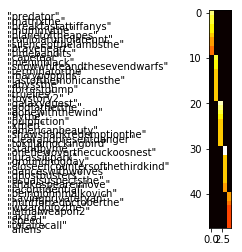

In [60]:
#Show titles theme heatmap

zz=np.resize(zz,(len(DC.keys()),zz.shape[1]))

for val, key in enumerate(DC.keys()):
        plt.text(-45, val + 1, key,
                 horizontalalignment='left',
                 verticalalignment='center'
                 )
plt.imshow(zz, cmap='hot', interpolation='nearest')
plt.show()

Overall, I did not find meaningful topics or themes from my movie titles using LDA model. I have tried usign the whole data set and using a subset of it after removing those titles with the smallest frequencies. 

My probability matrix and heat map visualizations suggest very low probabilities of titles within themes. At this point, I will attempt to use TF-IDF as a last resort in achieving my goal with this type of model. 

# Term Frequency * Inverse Document Frequency (TF-IDF)

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. Tf-idf is one of the most popular term-weighting schemes today; 83% of text-based recommender systems in digital libraries use tf-idf.

Variations of the tf–idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query. tf–idf can be successfully used for stop-words filtering in various subject fields, including text summarization and classification.

One of the simplest ranking functions is computed by summing the tf–idf for each query term; many more sophisticated ranking functions are variants of this simple model.https://en.wikipedia.org/wiki/Tf%E2%80%93idf

 I will try to implement the model as per info here:
https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3

In [61]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [62]:
#Recovering original dataframe for transfomation purposes
titles_trans.head()

,titles_lower,Users_count
2651,misérables les,3428
466,superman,2672
1848,babes in toyland,2653
2374,brady bunch movie the,2590
1178,four weddings and a funeral,2583


In [63]:
# I am getting inspiration from https://github.com/mayank408/TFIDF/blob/master/Sklearn%20TFIDF.ipynb
#https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3
    
#Importing module
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
#Initializing the model
tfidf = TfidfVectorizer()

In [65]:
#Extracting movie titles from dataframe into series
cols2 = list(titles_trans['titles_lower'].iloc[0:])
cols2 = [str(x) for x in cols2]
print([item for item in cols2])

['misérables les ', 'superman ', 'babes in toyland ', 'brady bunch movie the ', 'four weddings and a funeral ', 'titanic ', 'house of dracula ', 'notting hill ', 'untouchables the ', 'hardboiled lashou shentan ', 'bonnie and clyde ', 'all quiet on the western front ', 'princess mononoke the mononoke hime ', 'thing from another world the ', 'strangers on a train ', 'election ', 'big ', 'where the heart is ', 'sister act ', 'running man the ', 'stigmata ', 'hercules ', 'time to kill a ', 'raiders of the lost ark ', 'james and the giant peach ', 'reality bites ', 'who framed roger rabbit ', 'boys dont cry ', 'being john malkovich ', 'midnight run ', 'shanghai triad yao a yao yao dao waipo qiao ', 'prizzis honor ', 'seven se7en ', 'dead poets society ', 'hunchback of notre dame the ', 'world is not enough the ', 'wild wild west ', 'omega man the ', 'crying game the ', 'indiana jones and the temple of doom ', 'men in black ', 'life is beautiful la vita è bella ', 'guess whos coming to dinne

In [66]:
#Fitting the model
response = tfidf.fit_transform([item for item in cols2])

In [351]:
#Running the model while iterating through series of titles to obtain term frequency

feature_names = tfidf.get_feature_names()
for col in response.nonzero()[1]:
    print (feature_names[col], ' - ', response[0, col])

misérables  -  0.7210346272119993
les  -  0.6928990304230865
superman  -  0.0
babes  -  0.0
in  -  0.0
toyland  -  0.0
brady  -  0.0
bunch  -  0.0
movie  -  0.0
the  -  0.0
four  -  0.0
weddings  -  0.0
and  -  0.0
funeral  -  0.0
titanic  -  0.0
house  -  0.0
of  -  0.0
dracula  -  0.0
notting  -  0.0
hill  -  0.0
the  -  0.0
untouchables  -  0.0
hardboiled  -  0.0
lashou  -  0.0
shentan  -  0.0
and  -  0.0
bonnie  -  0.0
clyde  -  0.0
the  -  0.0
all  -  0.0
quiet  -  0.0
on  -  0.0
western  -  0.0
front  -  0.0
the  -  0.0
princess  -  0.0
mononoke  -  0.0
hime  -  0.0
the  -  0.0
thing  -  0.0
from  -  0.0
another  -  0.0
world  -  0.0
on  -  0.0
strangers  -  0.0
train  -  0.0
election  -  0.0
big  -  0.0
the  -  0.0
where  -  0.0
heart  -  0.0
is  -  0.0
sister  -  0.0
act  -  0.0
the  -  0.0
running  -  0.0
man  -  0.0
stigmata  -  0.0
hercules  -  0.0
time  -  0.0
to  -  0.0
kill  -  0.0
the  -  0.0
of  -  0.0
raiders  -  0.0
lost  -  0.0
ark  -  0.0
the  -  0.0
and  -  0.0
jam

dead  -  0.0
night  -  0.0
living  -  0.0
batman  -  0.0
absolute  -  0.0
power  -  0.0
sleepy  -  0.0
hollow  -  0.0
hard  -  0.0
die  -  0.0
the  -  0.0
and  -  0.0
of  -  0.0
indiana  -  0.0
jones  -  0.0
temple  -  0.0
doom  -  0.0
the  -  0.0
black  -  0.0
hole  -  0.0
moonraker  -  0.0
king  -  0.0
kong  -  0.0
superman  -  0.0
iii  -  0.0
deep  -  0.0
impact  -  0.0
notting  -  0.0
hill  -  0.0
pocahontas  -  0.0
iq  -  0.0
gremlins  -  0.0
the  -  0.0
terminator  -  0.0
total  -  0.0
recall  -  0.0
the  -  0.0
thing  -  0.0
do  -  0.0
right  -  0.0
the  -  0.0
under  -  0.0
down  -  0.0
rescuers  -  0.0
highlander  -  0.0
vacation  -  0.0
the  -  0.0
howard  -  0.0
duck  -  0.0
the  -  0.0
running  -  0.0
man  -  0.0
thunderball  -  0.0
the  -  0.0
and  -  0.0
of  -  0.0
indiana  -  0.0
jones  -  0.0
temple  -  0.0
doom  -  0.0
christmas  -  0.0
vacation  -  0.0
rear  -  0.0
window  -  0.0
ladyhawke  -  0.0
sneakers  -  0.0
cape  -  0.0
fear  -  0.0
the  -  0.0
sixth  -  0.0
se

as  -  0.0
gets  -  0.0
speed  -  0.0
cocoon  -  0.0
and  -  0.0
sex  -  0.0
lies  -  0.0
videotape  -  0.0
batman  -  0.0
mars  -  0.0
attacks  -  0.0
duck  -  0.0
soup  -  0.0
the  -  0.0
santa  -  0.0
clause  -  0.0
the  -  0.0
of  -  0.0
story  -  0.0
us  -  0.0
ronin  -  0.0
to  -  0.0
goes  -  0.0
mr  -  0.0
smith  -  0.0
washington  -  0.0
trading  -  0.0
places  -  0.0
jaws  -  0.0
robocop  -  0.0
the  -  0.0
arrival  -  0.0
the  -  0.0
fugitive  -  0.0
lethal  -  0.0
weapon  -  0.0
the  -  0.0
of  -  0.0
grapes  -  0.0
wrath  -  0.0
american  -  0.0
beauty  -  0.0
exotica  -  0.0
who  -  0.0
framed  -  0.0
roger  -  0.0
rabbit  -  0.0
willow  -  0.0
the  -  0.0
exorcist  -  0.0
rocky  -  0.0
iv  -  0.0
close  -  0.0
shave  -  0.0
the  -  0.0
man  -  0.0
who  -  0.0
knew  -  0.0
too  -  0.0
much  -  0.0
puppet  -  0.0
master  -  0.0
and  -  0.0
gods  -  0.0
monsters  -  0.0
the  -  0.0
of  -  0.0
village  -  0.0
damned  -  0.0
emma  -  0.0
doctor  -  0.0
dolittle  -  0.0
cinder

shentan  -  0.0
man  -  0.0
renaissance  -  0.0
man  -  0.0
demolition  -  0.0
mr  -  0.0
hollands  -  0.0
opus  -  0.0
the  -  0.0
one  -  0.0
flew  -  0.0
over  -  0.0
cuckoos  -  0.0
nest  -  0.0
when  -  0.0
harry  -  0.0
met  -  0.0
sally  -  0.0
the  -  0.0
house  -  0.0
cider  -  0.0
rules  -  0.0
la  -  0.0
confidential  -  0.0
the  -  0.0
of  -  0.0
planet  -  0.0
apes  -  0.0
the  -  0.0
warrior  -  0.0
13th  -  0.0
the  -  0.0
muppets  -  0.0
manhattan  -  0.0
take  -  0.0
pulp  -  0.0
fiction  -  0.0
the  -  0.0
with  -  0.0
gone  -  0.0
wind  -  0.0
rush  -  0.0
hour  -  0.0
breakfast  -  0.0
at  -  0.0
tiffanys  -  0.0
major  -  0.0
payne  -  0.0
the  -  0.0
of  -  0.0
oz  -  0.0
wizard  -  0.0
the  -  0.0
all  -  0.0
way  -  0.0
jingle  -  0.0
casino  -  0.0
the  -  0.0
of  -  0.0
legends  -  0.0
fall  -  0.0
kids  -  0.0
thing  -  0.0
swamp  -  0.0
striptease  -  0.0
aliens  -  0.0
the  -  0.0
kids  -  0.0
honey  -  0.0
shrunk  -  0.0
texas  -  0.0
happy  -  0.0
time  -

I believe there's something not 100% ok with my loop (above) or my data is not meant to be modelled this way, probably due to limited number of observations. My frequencies are really low or zero so I will try a different model for my movie engine recommendation.

# Model 2 - Item/User (Memory) based Collaborative Filtering - pending updating the code from here

The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that.

For instance, if user A likes movies 1, 2, 3 and user B likes movies 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use.

Item-item collaborative filtering tries finding movie’s look-alike. Once we have a movie’s look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. 

This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. Also with fixed number of movies, movie-movie look alike matrix is fixed over time.

For this I will build a similarity matrix which will consist of some distance metrics that measure the similarity between any two pairs of items. For the purpose of this implementation I will use Pearson Similarity.

Due to the limited computing power in my laptop, I will build the recommender system using only a subset of the ratings. In particular, I will take a random sample of 20,000 ratings (2.14%) from the 936,381 ratings.

I will split the dataset into testing and training. Cross_validation.train_test_split shuffles and splits the data into two datasets according to the percentage of test examples, which in this case is 0.2.

I choose to go back to my original Movielens files to gather more observations and avoid previous issues due to small dataset if possible

In [21]:
# Reading ratings file
# Ignore the timestamp column
ratings1 = pd.read_csv('ratings1.csv')

# Reading users file
users = pd.read_csv('users.csv')

# Reading movies file
movies = pd.read_csv('movies.csv')

In [25]:
# Fill NaN values in user_id and movie_id column with 0
ratings1['UserID'] = ratings1['UserID'].fillna(0)
ratings1['MovieID'] = ratings1['MovieID'].fillna(0)

# Replace NaN values in rating column with average of all values
ratings1['Rating'] = ratings1['Rating'].fillna(ratings1['Rating'].mean())

In [26]:
# Randomly sample 1% of the ratings dataset
small_data = ratings1.sample(frac=0.02)
# Check the sample info
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20004 entries, 533871 to 264673
Data columns (total 3 columns):
UserID     20004 non-null int64
MovieID    20004 non-null int64
Rating     20004 non-null int64
dtypes: int64(3)
memory usage: 625.1 KB
None


Now I use the scikit-learn library to split the dataset into testing and training. Cross_validation.train_test_split shuffles and splits the data into two datasets according to the percentage of test examples, which in this case is 0.2.

In [27]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(small_data, test_size=0.2)

C:\Users\loida\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Now I need to create a user-item matrix. Since I have splitted the data into testing and training, I need to create two matrices. The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings.

In [28]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.as_matrix(columns = ['UserID', 'MovieID', 'Rating'])
test_data_matrix = test_data.as_matrix(columns = ['UserID', 'MovieID', 'Rating'])

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(16003, 3)
(4001, 3)


Now I use the pairwise_distances function from sklearn to calculate the Pearson Correlation Coefficient. This method provides a safe way to take a distance matrix as input, while preserving compatibility with many other algorithms that take a vector array.

In [29]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[1.         0.82830896 0.88924154 0.99998979]
 [0.82830896 1.         0.99285623 0.82576852]
 [0.88924154 0.99285623 1.         0.8871652 ]
 [0.99998979 0.82576852 0.8871652  1.        ]]


In [30]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.         -0.01577105  0.00756667]
 [-0.01577105  1.         -0.06498506]
 [ 0.00756667 -0.06498506  1.        ]]


With the similarity matrix in hand, I can now predict the ratings that were not included with the data. Using these predictions, I can then compare them with the test data to attempt to validate the quality of our recommender model.

For the user-user CF case, I will look at the similarity between 2 users (A and B, for example) as weights that are multiplied by the ratings of a similar user B (corrected for the average rating of that user). I also need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that I am trying to predict. The idea here is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values.

In [31]:
# Function to predict ratings# Functi 
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

The most popular metric used to evaluate accuracy of predicted ratings is Root Mean Squared Error (RMSE). I will use the mean_square_error (MSE) function from sklearn, where the RMSE is just the square root of MSE.

I'll use the scikit-learn's mean squared error function as my validation metric. Comparing user- and item-based collaborative filtering, it looks like user-based collaborative filtering gives a better result.

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [33]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 1410.225828776803
Item-based CF RMSE: 1624.3672178050713


In [34]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 692.1809566507295
Item-based CF RMSE: 147.3770624970949


RMSE of training of model is a metric which measure how much the signal and the noise is explained by the model. I noticed that my RMSE is quite big. I suppose I might have overfitted the training data.

Overall, Memory-based Collaborative Filtering is easy to implement and produce reasonable prediction quality. However, there are some drawback of this approach:

It doesn't address the well-known cold-start problem, that is when new user or new item enters the system.
It can't deal with sparse data, meaning it's hard to find users that have rated the same items.
It suffers when new users or items that don't have any ratings enter the system.
It tends to recommend popular items.

# Evaluating the new model fit

There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted ratings is Root Mean Squared Error (RMSE). I will use the mean_square_error (MSE) function from sklearn, where the RMSE is just the square root of MSE. I’ll use the scikit-learn’s mean squared error function as my validation metric. Comparing user- and item-based collaborative filtering, it looks like user-based collaborative filtering gives a better result.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))
## Output
User-based CF RMSE: 699.9584792778463
Item-based CF RMSE: 114.97271725933925

RMSE of training of model is a metric which measure how much the signal and the noise is explained by the model. I noticed that my RMSE is quite big. I suppose I might have overfitted the training data.

Overall, Memory-based Collaborative Filtering is easy to implement and produce reasonable prediction quality. However, there are some drawback of this approach:

It doesn’t address the well-known cold-start problem, that is when new user or new item enters the system.
It can’t deal with sparse data, meaning it’s hard to find users that have rated the same items.
It suffers when new users or items that don’t have any ratings enter the system.
It tends to recommend popular items.

In the previous attempt, I have used memory-based collaborative filtering to make movie recommendations from users’ ratings data. I can only try them on a very small data sample (20,000 ratings), and ended up getting pretty high Root Mean Squared Error (bad recommendations). Memory-based collaborative filtering approaches that compute distance relationships between items or users have these two major issues:

It doesn’t scale particularly well to massive datasets, especially for real-time recommendations based on user behavior similarities — which takes a lot of computations.
Ratings matrices may be overfitting to noisy representations of user tastes and preferences. When we use distance based “neighborhood” approaches on raw data, we match to sparse low-level details that we assume represent the user’s preference vector instead of the vector itself.


Memory-based collaborative filtering approaches that compute distance relationships between items or users have these two major issues:

It doesn't scale particularly well to massive datasets, especially for real-time recommendations based on user behavior similarities - which takes a lot of computations.
Ratings matrices may be overfitting to noisy representations of user tastes and preferences. When we use distance based "neighborhood" approaches on raw data, we match to sparse low-level details that we assume represent the user's preference vector instead of the vector itself.

Thus I'd need to apply Dimensionality Reduction technique to derive the tastes and preferences from the raw data, otherwise known as doing low-rank matrix factorization. Why reduce dimensions?

I can discover hidden correlations / features in the raw data.
I can remove redundant and noisy features that are not useful.
I can interpret and visualize the data easier.
I can also access easier data storage and processing.

I will try my last model...

# Additional approach - Model based Collaborative Filtering (or low dimensional factor model)

https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0

In this approach, CF models are developed using machine learning algorithms to predict user’s rating of unrated items. As per my understanding, the algorithms in this approach can further be broken down into 3 sub-types.

Matrix Factorization (MF): The idea behind such models is that attitudes or preferences of a user can be determined by a small number of hidden factors. We can call these factors as Embeddings.
Matrix decomposition can be reformulated as an optimization problem with loss functions and constraints. Now the constraints are chosen based on property of our model. For e.g. for Non negative matrix decomposition, we want non negative elements in resultant matrices.

#Embeddings:
Intuitively, we can understand embeddings as low dimensional hidden factors for items and users. For e.g. say we have 5 dimensional (i.e. D or n_factors = 5 in above figure) embeddings for both items and users (# 5 chosen randomly). Then for user-X & movie-A, we can say the those 5 numbers might represent 5 different characteristics about the movie, like (i) how much movie-A is sci-fi intense (ii) how recent is the movie (iii) how much special effects are in movie A (iv) how dialogue driven is the movie (v) how CGI driven is the movie. Likewise, 5 numbers in user embedding matrix might represent, (i) how much does user-X like sci-fi movie (ii) how much does user-X like recent movies …and so on. In above figure, a higher number from dot product of user-X and movie-A matrix means that movie-A is a good recommendation for user-X.

Matrix factorization can be done by various methods and there are several research papers out there. In next section, there is python implementation for orthogonal factorization (SVD) or probabilistic factorization (PMF) or Non-negative factorization (NMF).

For SVD or PCA, we decompose our original sparse matrix into product of 2 low rank orthogonal matrices.

The Surprise package has been specially developed to make recommendation based on collaborative filtering easy. It has default implementation for a variety of CF algorithms.

I will use the Surprise library that provided various ready-to-use powerful prediction algorithms including (SVD) to evaluate its RMSE (Root Mean Squared Error) on the MovieLens dataset. It is a Python scikit building and analyzing recommender systems.

In [52]:
# Loading Surprise
from surprise import SVD
from surprise import Dataset
from surprise import KNNBasic
from surprise.model_selection import cross_validate


In [45]:
#Quick data processign needed prior to Matrix Factorization
probabilistic factorization (PMF) or Non-negative factorization (NMF).

from surprise import Reader, Dataset

# A reader is still needed but only the rating_scale param is required.
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(0.5, 5.0))

# The columns must correspond to user id, movie id and ratings (in that order).
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)


In [48]:
# Split data into 5 folds

data.split(n_folds=5)

from surprise import SVD, evaluate
from surprise import NMF

# Support Vector Decomposition (SVD)

In [88]:
algo1 = SVD()
evaluate(algo1, data, measures=['RMSE'])

C:\Users\loida\Anaconda3\lib\site-packages\surprise\evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)


Evaluating RMSE of algorithm SVD.



C:\Users\loida\Anaconda3\lib\site-packages\surprise\dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


------------
Fold 1
RMSE: 0.8710
------------
Fold 2
RMSE: 0.8732
------------
Fold 3
RMSE: 0.8747
------------
Fold 4
RMSE: 0.8765
------------
Fold 5
RMSE: 0.8727
------------
------------
Mean RMSE: 0.8736
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.8710273789835372,
                             0.8732118282171519,
                             0.8747375156960648,
                             0.8764758129821352,
                             0.8726571829371907]})

# Non-Negative Matrix Factorization (NMF)

In [50]:
algo2 = NMF()
evaluate(algo2, data, measures=['RMSE'])

C:\Users\loida\Anaconda3\lib\site-packages\surprise\evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)


Evaluating RMSE of algorithm NMF.



C:\Users\loida\Anaconda3\lib\site-packages\surprise\dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


------------
Fold 1
RMSE: 0.9137
------------
Fold 2
RMSE: 0.9168
------------
Fold 3
RMSE: 0.9162
------------
Fold 4
RMSE: 0.9213
------------
Fold 5
RMSE: 0.9132
------------
------------
Mean RMSE: 0.9162
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.9137259618729943,
                             0.9167923522648577,
                             0.9161686602131343,
                             0.9212645398837328,
                             0.9131765058836686]})

# K-Nearest Neighbour (KNN)

In [53]:
algo3 = KNNBasic()
evaluate(algo3, data, measures=['RMSE'])

C:\Users\loida\Anaconda3\lib\site-packages\surprise\evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)


Evaluating RMSE of algorithm KNNBasic.



C:\Users\loida\Anaconda3\lib\site-packages\surprise\dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9212
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9239
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9249
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9249
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9199
------------
------------
Mean RMSE: 0.9230
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.9211699098280236,
                             0.9239062010591066,
                             0.9249138994682294,
                             0.9248759163196184,
                             0.9199401970397874]})

# Comparisons and Conclusions on Matrix Factorization methods

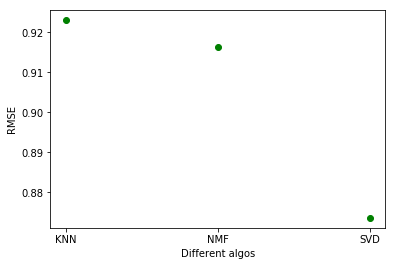

In [89]:
#The best RMSE is 0.8742 and is given by SVD

rmses = [.8736, .9162, .9230, ]
algos = ['SVD', "NMF",'KNN']
plt.plot(algos, rmses, 'go',  )
plt.xlabel("Different algos")
plt.ylabel("RMSE")
plt.show()

# SVD set up for prediction

Scipy and Numpy both have functions to do the singular value decomposition. I'm going to use the Scipy function svds because it let's me choose how many latent factors I want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [58]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [59]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [63]:
# Also let's count the number of unique users and movies

n_users = ratings.UserID.unique().shape[0]
n_movies = ratings.MovieID.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Now I want the format of my ratings matrix to be one row per user and one column per movie. To do so, I'll pivot ratings to get that and call the new variable Ratings (with a capital *R).

In [67]:
Ratings1 = ratings.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
Ratings1.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Last but not least, I need to de-normalize the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [68]:
R = Ratings1.as_matrix()
user_ratings1_mean = np.mean(R, axis = 1)
Ratings1_demeaned = R - user_ratings1_mean.reshape(-1, 1)

With my ratings matrix properly formatted and normalized, I'm ready to do some dimensionality reduction (SVD)

I'm going to use the Scipy function svds because it let's me choose how many latent factors I want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [70]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Ratings1_demeaned, k = 50)

As I'm going to leverage matrix multiplication to get predictions, I'll convert the $\Sigma$ (now are values) to the diagonal matrix form

In [71]:
sigma = np.diag(sigma)

I now have everything I need to make movie ratings predictions for every user. I can do it all at once by following the math and matrix multiply $U$, $\Sigma$, and $V^{T}$ back to get the rank $k=50$ approximation of $A$

# Making a prediction

First, I need to add the user means back to get the actual star ratings prediction.

In [72]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings1_mean.reshape(-1, 1)

With the predictions matrix for every user, I can build a function to recommend movies for any user. I return the list of movies the user has already rated, for the sake of comparison.

In [74]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.110151,0.046010,0.006934,-0.015940,-0.050080,-0.052539,0.507189,0.033830,0.125706,0.199244


Now I write a function to return the movies with the highest predicted rating that the specified user hasn't already rated. Though I didn't use any explicit movie content features (such as genre or title), I'll merge in that information to get a more complete picture of the recommendations.

In [78]:
def recommend_movies(predictions, UserID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = UserID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.UserID == (UserID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'MovieID', right_on = 'MovieID').
                     sort_values(['Rating'], ascending=False)
                 )

    print ('User {0} has already rated {1} movies'.format(UserID, user_full.shape[0]))
    print ('Recommending highest {0} predicted ratings movies not already rated'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['MovieID'].isin(user_full['MovieID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'MovieID',
               right_on = 'MovieID').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

Let's try to recommend 20 movies for user with ID 1310.

In [79]:
already_rated, predictions = recommend_movies(preds, 1310, movies, ratings, 20)

User 1310 has already rated 24 movies
Recommending highest 20 predicted ratings movies not already rated


In [80]:
# Top 20 movies that User 1310 has rated 
already_rated.head(20)

,UserID,MovieID,Rating,Timestamp,Title,Genres
5,1310,2248,5,974781573,Say Anything... (1989),Comedy|Drama|Romance
6,1310,2620,5,974781573,This Is My Father (1998),Drama|Romance
7,1310,3683,5,974781935,Blood Simple (1984),Drama|Film-Noir
15,1310,1704,5,974781573,Good Will Hunting (1997),Drama
1,1310,1293,5,974781839,Gandhi (1982),Drama
12,1310,3101,4,974781573,Fatal Attraction (1987),Thriller
11,1310,1343,4,974781534,Cape Fear (1991),Thriller
20,1310,2000,4,974781892,Lethal Weapon (1987),Action|Comedy|Crime|Drama
18,1310,3526,4,974781892,Parenthood (1989),Comedy|Drama
17,1310,3360,4,974781935,Hoosiers (1986),Drama


In [81]:
# Top 20 movies that User 1310 hopefully will enjoy
predictions

,MovieID,Title,Genres
1618,1674,Witness (1985),Drama|Romance|Thriller
1880,1961,Rain Man (1988),Drama
1187,1210,Star Wars,NaN
1216,1242,Glory (1989),Action|Drama|War
1202,1225,Amadeus (1984),Drama
1273,1302,Field of Dreams (1989),Drama
1220,1246,Dead Poets Society (1989),Drama
1881,1962,Driving Miss Daisy (1989),Drama
1877,1957,Chariots of Fire (1981),Drama
1938,2020,Dangerous Liaisons (1988),Drama|Romance


These look like pretty good recommendations. It's good to see that, although I didn't actually use the genre of the movie as a feature, the truncated matrix factorization features "picked up" on the underlying tastes and preferences of the user. I've recommended some comedy, drama, and romance movies - all of which were genres of some of this user's top rated movies.

# Training on our dataset with SVD and making ratings predictions

In [90]:
trainset = data.build_full_trainset()
algo1.train(trainset)

C:\Users\loida\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


I'll pick again user with ID 1310 and check the ratings he has given.

In [91]:
ratings[ratings['UserID'] == 1310]

,UserID,MovieID,Rating,Timestamp
215928,1310,2988,3,974781935
215929,1310,1293,5,974781839
215930,1310,1295,2,974782001
215931,1310,1299,4,974781701
215932,1310,2243,4,974782001
215933,1310,2248,5,974781573
215934,1310,2620,5,974781573
215935,1310,3683,5,974781935
215936,1310,3685,4,974781935
215937,1310,1185,4,974781839


Now let's use SVD to predict the rating that User with ID 1310 will give to a random movie (let's say with Movie ID 1994).

In [93]:
algo1.predict(1310, 1994)

Prediction(uid=1310, iid=1994, r_ui=None, est=3.4299338918767885, details={'was_impossible': False})

For movie with ID 1994, I get an estimated prediction of 3.349. The recommender system works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

# Conclusion

In this notebook, I attempted to build a model-based Collaborative Filtering movie recommendation sytem based on latent features from a low rank matrix factorization method called SVD. As it captures the underlying features driving the raw data, it can scale significantly better to massive datasets as well as make better recommendations based on user's tastes.

However, we still likely lose some meaningful signals by using a low-rank approximation. Specifically, there's an interpretability problem as a singular vector specifies a linear combination of all input columns or rows. There's also a lack of sparsity when the singular vectors are quite dense. Thus, SVD approach is limited to linear projections.

# Model interpretation - pending

# Improvement areas - pending

# Model optimisation and associated costs/benefits - pending